In [1]:
import os
import numpy as np
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.features import shapes
from shapely.geometry import shape
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

# PATHS
REPO_ROOT = os.path.join(os.path.expanduser("~"), "turing-geospatial-analyst-portfolio")
PROJECT = os.path.join(REPO_ROOT, "python_geospatial", "project03_landcover_classification")

SENTINEL = os.path.join(PROJECT, "data", "raw", "sentinel2_denpasar_multiband.tif")
TRAIN = os.path.join(PROJECT, "data", "training", "training_polygons_auto.geojson")

OUT_TIF = os.path.join(PROJECT, "data", "processed", "landcover_map.tif")
OUT_PNG = os.path.join(PROJECT, "outputs", "maps", "landcover_map.png")
OUT_GPKG = os.path.join(PROJECT, "outputs", "shapefiles", "landcover_polygonized.gpkg")


In [2]:
with rasterio.open(SENTINEL) as src:
    meta = src.meta.copy()
    transform = src.transform
    crs = src.crs
    h, w = src.height, src.width
    print("Bands:", src.count, "Size:", (h,w))
    
    b2 = src.read(1).astype('float32')
    b3 = src.read(2).astype('float32')
    b4 = src.read(3).astype('float32')
    b8 = src.read(4).astype('float32')
    b11 = src.read(5).astype('float32')
    b12 = src.read(6).astype('float32')

# autoscale if needed
def scale(b):
    return b/10000 if np.nanmax(b) > 2 else b

b2,b3,b4,b8,b11,b12 = map(scale,[b2,b3,b4,b8,b11,b12])

# Feature stack
ndvi = (b8 - b4)/(b8 + b4 + 1e-8)
ndwi = (b3 - b8)/(b3 + b8 + 1e-8)
ndbi = (b11 - b8)/(b11 + b8 + 1e-8)

stack = np.dstack([b2,b3,b4,b8,b11,b12,ndvi,ndwi,ndbi])
print("Stack shape:", stack.shape)


Bands: 7 Size: (2784, 2228)
Stack shape: (2784, 2228, 9)


In [3]:
gdf = gpd.read_file(TRAIN)
print("Training polygons:", len(gdf))
gdf.head()


Training polygons: 3709


,class,area_m2,geometry
0,3,2151.390137,"POLYGON ((115.18881 -8.54999, 115.18953 -8.549..."
1,3,2151.390137,"POLYGON ((115.21765 -8.54999, 115.21837 -8.549..."
2,2,2053.599676,"POLYGON ((115.21909 -8.54999, 115.2198 -8.5499..."
3,3,2151.390137,"POLYGON ((115.22537 -8.54999, 115.22609 -8.549..."
4,1,5378.474074,"POLYGON ((115.19851 -8.54999, 115.20004 -8.549..."


In [4]:
X = []
y = []

with rasterio.open(SENTINEL) as src:
    for idx, row in gdf.iterrows():
        mask = rasterio.features.geometry_mask(
            [row.geometry],
            transform=src.transform,
            invert=True,
            out_shape=(src.height, src.width)
        )
        pixels = stack[mask]
        labels = np.full(len(pixels), row["class"])
        
        X.append(pixels)
        y.append(labels)

X = np.vstack(X)
y = np.hstack(y)

print("Training samples:", len(y))


Training samples: 6171447


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    n_jobs=-1,
    random_state=42
)

clf.fit(X_train, y_train)

print("Model trained!")


Model trained!


In [6]:
pred = clf.predict(X_test)

print(classification_report(y_test, pred))

cm = confusion_matrix(y_test, pred)
print("Confusion Matrix:\n", cm)


              precision    recall  f1-score   support

           1       1.00      0.99      0.99    522528
           2       0.60      0.25      0.36     35179
           3       0.91      0.92      0.91    311955
           4       0.86      0.90      0.88    364628

    accuracy                           0.92   1234290
   macro avg       0.84      0.77      0.78   1234290
weighted avg       0.92      0.92      0.92   1234290

Confusion Matrix:
 [[517511      8   1875   3134]
 [    18   8931      7  26223]
 [   237     23 285902  25793]
 [  1587   5977  28119 328945]]


In [7]:
H,W,_ = stack.shape
flat = stack.reshape(-1, stack.shape[2])

pred_full = clf.predict(flat)
pred_img = pred_full.reshape(H,W)

print("Prediction complete.")


Prediction complete.


In [8]:
meta2 = meta.copy()
meta2.update({
    "count": 1,
    "dtype": "uint8"
})

with rasterio.open(OUT_TIF, "w", **meta2) as dst:
    dst.write(pred_img.astype("uint8"), 1)

print("Saved:", OUT_TIF)


Saved: C:\Users\User\turing-geospatial-analyst-portfolio\python_geospatial\project03_landcover_classification\data\processed\landcover_map.tif


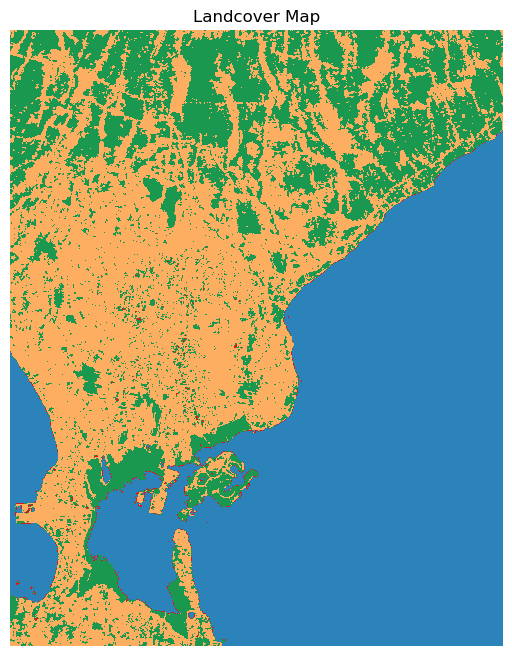

Saved: C:\Users\User\turing-geospatial-analyst-portfolio\python_geospatial\project03_landcover_classification\outputs\maps\landcover_map.png


In [11]:
import matplotlib.colors as mcolors

colors = ["#2b83ba","#d7191c","#1a9850","#fdae61"]  # water, urban, vegetation, bare
cmap = mcolors.ListedColormap(colors)

plt.figure(figsize=(8,8))
plt.imshow(pred_img, cmap=cmap)
plt.title("Landcover Map")
plt.axis("off")
plt.savefig(OUT_PNG, dpi=200, bbox_inches='tight')
plt.show()

print("Saved:", OUT_PNG)


In [10]:
shapes_list = []
for geom, val in shapes(pred_img.astype('uint8'), mask=None, transform=transform):
    shapes_list.append({"geometry": shape(geom), "class": int(val)})

poly = gpd.GeoDataFrame(shapes_list, crs=crs)

poly.to_file(OUT_GPKG, driver="GPKG")
print("Saved:", OUT_GPKG)


Saved: C:\Users\User\turing-geospatial-analyst-portfolio\python_geospatial\project03_landcover_classification\outputs\shapefiles\landcover_polygonized.gpkg


In [12]:
print("OUT_PNG path →", OUT_PNG)
print("Folder exists →", os.path.exists(os.path.dirname(OUT_PNG)))


OUT_PNG path → C:\Users\User\turing-geospatial-analyst-portfolio\python_geospatial\project03_landcover_classification\outputs\maps\landcover_map.png
Folder exists → True
